In [2]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

u=x

In [ ]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points
    
def plot_losses(epochs, laplace_losses, dirichlet_losses, neumann_losses, total_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, laplace_losses, label="Laplace Loss")
    plt.plot(epochs, dirichlet_losses, label="Dirichlet Loss")
    plt.plot(epochs, total_losses, label="Total Loss")
    plt.plot(epochs, neumann_losses, label="Neumann Loss")
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()
#_____________________________________________________________________________________________________________

# Boundary points and targets storage
boundary_points_dirichlet = []
boundary_target_dirichlet = []
boundary_points_neumann = []

# Dirichlet boundary conditions
dirichlet_boundaries = [
    ('vertical', 0, 0, 1, 1000, 0),  # Left boundary
    ('vertical', 1, 0, 1, 1000, 1),  # Right boundary
    # ('horizontal', 0, 0, 1, 100, 1),  # Bottom boundary
    # ('horizontal', 1, 0, 1, 100, 0)   # Top boundary
]

for axis, place, start, end, num_points, head in dirichlet_boundaries:
    boundary_points, boundary_targets = create_boundary_points(axis, place, start, end, num_points, head)
    boundary_points_dirichlet.append(boundary_points)
    boundary_target_dirichlet.append(boundary_targets)

# Concatenate Dirichlet boundary points and targets
boundary_points_dirichlet = torch.cat(boundary_points_dirichlet, dim=0).requires_grad_(True)
boundary_target_dirichlet = torch.cat(boundary_target_dirichlet, dim=0)

# Neumann boundary conditions
neumann_boundaries = [
    # ('vertical', 0, 0, 1, 100),  # Left boundary
    # ('vertical', 1, 0, 1, 100),  # Right boundary
    ('horizontal', 0, 0, 1, 1000),  # Bottom boundary
    ('horizontal', 1, 0, 1, 1000)   # Top boundary
]

for axis, place, start, end, num_points in neumann_boundaries:
    boundary_points = create_boundary_points(axis, place, start, end, num_points)
    boundary_points_neumann.append(boundary_points)

# Concatenate Neumann boundary points
boundary_points_neumann = torch.cat(boundary_points_neumann, dim=0).requires_grad_(True)

# Creating domain points
num_domain_points=1000
x = torch.rand((num_domain_points,1),requires_grad=True) #Need to be changed to the actual domain
y = torch.rand((num_domain_points,1),requires_grad=True) #Need to be changed to the actual domain
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses = []
neumann_losses = []
total_losses = []
epochs_recorded = []



#Defining changeable parameters:
model=pinn(hidden_size=64, hidden_layers=3) # to be used for evaluating u at boundaries and inside the domain
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20) #Using the Adam optimizer
lambda_laplace, lambda_dirichlet, lambda_neumann = 10000,500,500  #Weights for the losses
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, verbose=True)
epochs=75

#Training loop:
for epoch in range(epochs):
    # optimizer.zero_grad() #Have to zero the gradients at the start of each epoch

    
    # Backward pass
    # loss.backward()
    # Update 
    
    def closure():
        optimizer.zero_grad()  # Clear previous gradients
        loss_laplace = laplace_residual(model, train_points)
        loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
        loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')

        # Add other boundary losses if needed
        total_loss =loss_laplace * lambda_laplace  + loss_dirichlet * lambda_dirichlet + loss_neumann * lambda_neumann
        
        total_loss.backward()  # Compute gradients
        return total_loss

    # Step with LBFGS, passing in the closure

    optimizer.step(closure)    

    #losses
    loss_laplace=laplace_residual(model,train_points)
    loss_dirichlet = loss_dirichlet_boundary(model, boundary_points_dirichlet, boundary_target_dirichlet)
    loss_neumann = loss_neumann_boundary(model, boundary_points_neumann, axis='horizontal')
    loss=loss_laplace * lambda_laplace  + loss_dirichlet * lambda_dirichlet + loss_neumann * lambda_neumann
    # Append losses to the lists
    laplace_losses.append(loss_laplace.item()) 
    dirichlet_losses.append(loss_dirichlet.item())
    neumann_losses.append(loss_neumann.item())
    total_losses.append(loss.item())
    epochs_recorded.append(epoch) 

    # scheduler.step(loss)

    # Logging
    if epoch % 74 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.3E}, Domain Loss: {loss_laplace.item():.3E}, Boundary Loss Dirichlet: {loss_dirichlet.item():.3E}")
        plot_losses(epochs_recorded, laplace_losses, dirichlet_losses, neumann_losses, total_losses)

c:\Users\jolu2\H24\venv_torch\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


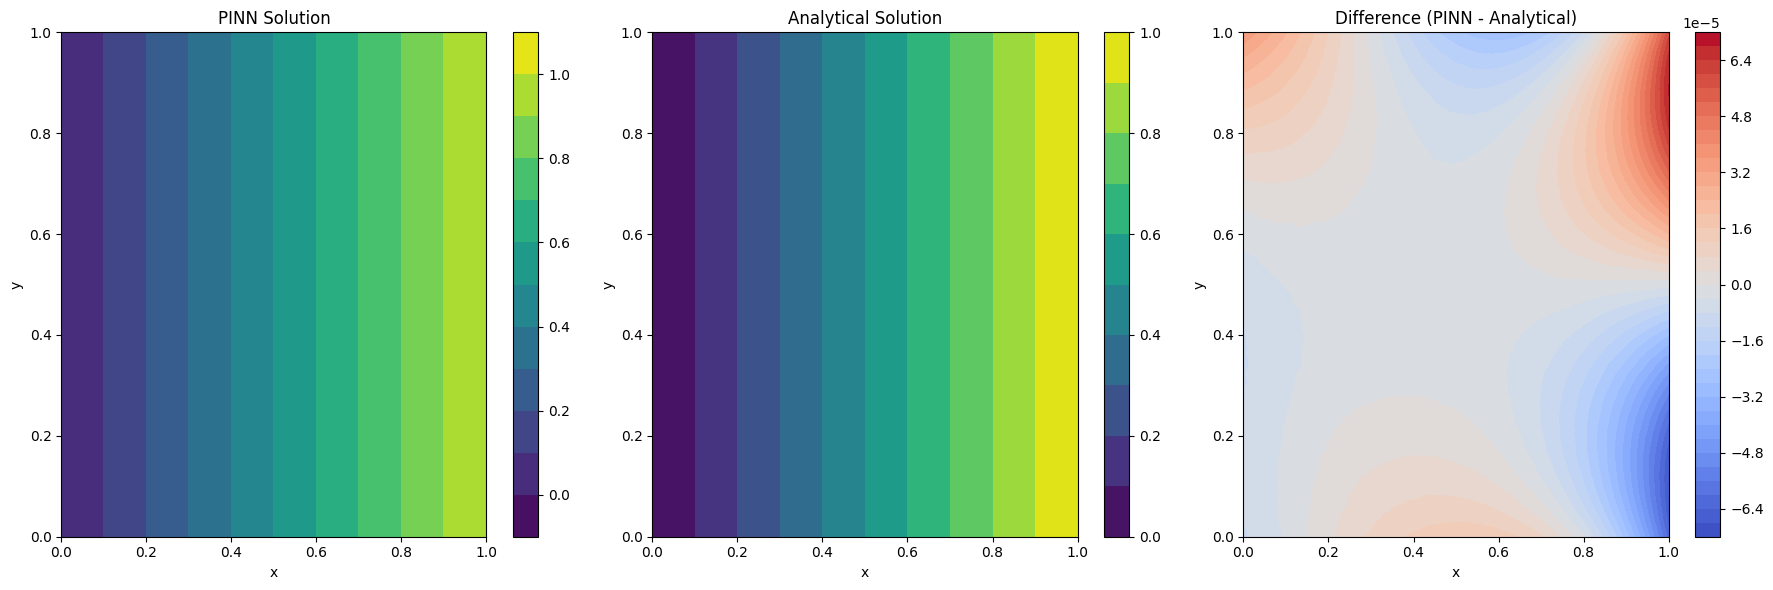

Maximum absolute difference: 6.819E-05, Mean absolute difference: 9.786E-06


In [4]:
# Define the grid
num = 100
x = y = torch.linspace(0, 1, num)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Assume `model` is your trained PINN model

# PINN solution
u_predicted = model(test_points).detach().numpy().reshape(num, num)  # Convert to numpy array for plotting

# Analytical solution
u_analytical = X.numpy()  # Linear solution u(x, y) = x, independent of y

# Difference between PINN solution and analytical solution
u_difference = u_predicted - u_analytical

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: PINN Solution
c1 = axs[0].contourf(X.numpy(), Y.numpy(), u_predicted, levels=10, cmap="viridis")
fig.colorbar(c1, ax=axs[0])
axs[0].set_title("PINN Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# Plot 2: Analytical Solution
c2 = axs[1].contourf(X.numpy(), Y.numpy(), u_analytical, levels=10, cmap="viridis")
fig.colorbar(c2, ax=axs[1])
axs[1].set_title("Analytical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Plot 3: Difference (PINN - Analytical)
c3 = axs[2].contourf(X.numpy(), Y.numpy(), u_difference, levels=40, cmap="coolwarm")
fig.colorbar(c3, ax=axs[2])
axs[2].set_title("Difference (PINN - Analytical)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")

plt.tight_layout()  # Adjust layout to reduce whitespace
plt.show()

print(f"Maximum absolute difference: {np.abs(u_difference).max():.3E}, Mean absolute difference: {np.abs(u_difference).mean():.3E}")
